In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import gzip
import numpy as np

Let's start by getting familiar with the data we'll be using, the Fashion MNIST dataset. This dataset contains 70,000 grayscale images of articles of clothing &mdash; 60,000 meant to be used for training and 10,000 meant for testing. The images are square and contain 28 &times; 28 = 784 pixels, where each pixel is represented by a value between 0 and 255. Each of these images is associated with a label, which is an integer between 0 and 9 that classifies the article of clothing. The following dictionary helps us understand the clothing categories corresponding to these integer labels:

In [3]:
labels_map = {
  0: 'T-Shirt',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle Boot',
}

If you're following this code but executing it outside of this Microsoft Learn sandbox notebook environment, you can load Fashion MNIST by calling the [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) method of the Fashion MNIST dataset in the Keras API, as you can see in the commented out code below. Keras provides an easy way to get not only Fashion MNIST, but many other popular datasets through [tk.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). In this Learn sandbox notebook we already have the data locally, so we'll load it directly instead, and create four NumPy arrays containing the training and test data and labels. 

In [4]:
# (training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

def read_images(path: str, image_size: int, num_items: int) -> np.ndarray:
  with gzip.open(path, 'rb') as file:
    data = np.frombuffer(file.read(), np.uint8, offset=16)
    data = data.reshape(num_items, image_size, image_size)
  return data

def read_labels(path: str, num_items: int) -> np.ndarray:
  with gzip.open(path, 'rb') as file:
    data = np.frombuffer(file.read(num_items + 8), np.uint8, offset=8)
    data = data.astype(np.int64)
  return data

image_size = 28
num_train = 60000
num_test = 10000

training_images = read_images('data/FashionMNIST/raw/train-images-idx3-ubyte.gz', image_size, num_train)
test_images = read_images('data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz', image_size, num_test)
training_labels = read_labels('data/FashionMNIST/raw/train-labels-idx1-ubyte.gz', num_train)
test_labels = read_labels('data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz', num_test)

Now that we have the data, we can display a sampling of images and corresponding labels from the training data, to get a feel for the data we'll be working with.

Matplotlib is building the font cache; this may take a moment.


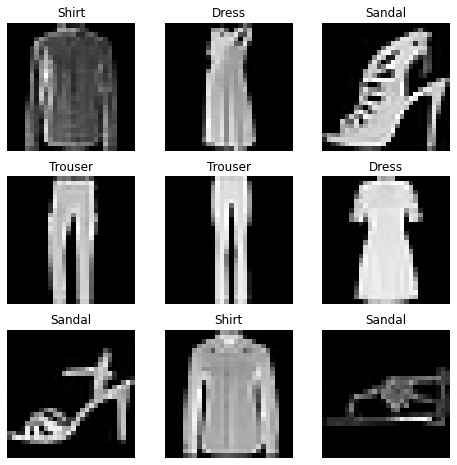

In [5]:
import random
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols = 3
rows = 3
for i in range(1, cols * rows + 1):
  sample_idx = random.randint(0, len(training_images))
  image = training_images[sample_idx]
  label = training_labels[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(image.squeeze(), cmap='gray')
plt.show()


Let's inspect the first label in the training data:

In [6]:
training_labels[0]

9

As we saw in the `labels_map` dictionary we printed earlier, this corresponds to an "Ankle boot." Now let's inspect the image that corresponds to this label:  

In [7]:
training_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

An image is composed of pixel values, and each pixel in the image is of type unsigned int and contains a value between 0 and 255.

For such a small dataset, we could just use the NumPy arrays given to us by Keras to train the neural network. However, if we had a large dataset, we would need to wrap it in a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instance, which handles large data better by making it easy to keep just a portion of it in memory. We've decided to wrap our data in a `Dataset` in this sample, so you're prepared to work with large data in the future.

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

You saw earlier that each pixel of the image is represented by an unsigned int. In machine learning, we generally want the pixel values of our training data to be floating-point numbers between 0 and 1, so we convert them in the following way:

In [9]:
train_dataset = train_dataset.map(lambda image, label: (float(image) / 255.0, label))
test_dataset = test_dataset.map(lambda image, label: (float(image) / 255.0, label))

You may have noticed that each value returned by the `Dataset` is a tuple containing an image and a label. We divide each value in the image by 255, and we keep the label as is. Let's inspect the values of the same image we inspected earlier, to see the difference. 

In [10]:
train_dataset.as_numpy_iterator().next()[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

As expected, the pixel values are now floating-point numbers between 0 and 1. 

Notice that now that we have a `Dataset`, we can no longer index it the same way as a NumPy array. Instead, we get an iterator by calling the `as_numpy_iterator` method, and we advance it by calling its `next` method. At this point, we have a tuple containing an image and the corresponding label, so we can get the element at index 0 to inspect the image.

Finally, we tell the `Dataset` to give us batches of data of size 64, and we shuffle the data:

In [11]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size).shuffle(500)
test_dataset = test_dataset.batch(batch_size).shuffle(500)

By specifying the batch size, we're telling the `Dataset` that when we iterate over it, we want to receive not one, but a batch of 64 items instead. If we print the length of the first item returned by the iterator, we'll see that we in fact get 64. 

In [12]:
len(train_dataset.as_numpy_iterator().next()[0])

64

Why do we want to get batches of 64 when iterating over the `Dataset`? We'll come back to that in the section on training. But first we need to learn about the neural network architecture we'll use for this sample.